## Imports and functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import itertools
import ot
import glob
import os

In [3]:
def Fourier1(mu, nu, T=2 * np.pi) -> float:
    mu_hat = np.fft.fft2(mu)
    nu_hat = np.fft.fft2(nu)
    m, n = mu.shape
    dxdy = (m / T) * (n / T)
    
    integral = 0

    for y in range(n):
        for x in range(m):
            if x == 0 and y == 0:
                continue
            
            kx = x * (2 * np.pi / m)
            ky = y * (2 * np.pi / n)

            # Compute the squared magnitude of the frequency vector
            k_squared = kx**2 + ky**2

            # Increment the integral value
            diff = mu_hat[y, x] - nu_hat[y, x]
            integral += (np.abs(diff) ** 2) / k_squared * dxdy

    integral = np.sqrt(((1 / T) ** 2) * integral)

    return integral


def Fourier2(a, b, T=2*np.pi) -> float:
    m, n = np.shape(a)
    dxdy = (T / m) * (T / n)

    # Normalize a and b
    a /= np.sum(a)
    b /= np.sum(b)

    # Calculate expected values and translation vector efficiently
    expected_value_a = np.array([np.sum(a * np.arange(m)[:, None]), np.sum(a * np.arange(n))])
    expected_value_b = np.array([np.sum(b * np.arange(m)[:, None]), np.sum(b * np.arange(n))])
    translation_vector = expected_value_a - expected_value_b

    # Perform FFT
    fa = np.fft.fftshift(np.fft.fft2(a))
    fb = np.fft.fftshift(np.fft.fft2(b))

    # Calculate distance considering the translation vector
    integral = 0
    for y in range(-n//2, n//2):
        for x in range(-m//2, m//2):
            # Avoid division by zero for the zero frequency component
            if x == 0 and y == 0:
                continue

            kx = x * T / m
            ky = y * T / n

            k_squared = kx ** 2 + ky ** 2
            trasl = np.exp((2 * np.pi * 1j * translation_vector[0] * x) / m) * np.exp(
                (2 * np.pi * 1j * translation_vector[1] * y) / n)
            integral += ((np.abs(fa[x, y] - fb[x, y] * trasl)) ** 2) / (k_squared ** 2) * dxdy

    C = (((1 / T) ** 2) * integral) ** (1 / 2)  # This is essentially the difference between a and b_moved
    distance = np.sqrt((C ** 2) + (np.sum(translation_vector ** 2)))  # Here we add the translation vector and normalize

    return distance


def calculate_costs(size, distance_metric='L1'):
    """
    This function of an array or image and calculates the cost from it to itself.

    Parameters:
    - `size` (int or tuple): representing the object on which we would like to calculate costs.

    Returns:
    - `costs` (numpy.ndarray): A 2D array representing the matrix of costs of transporting pixels
                                from the first image to the second image.
    """
    # 2D case:
    if len(size) == 2:
        I, J = np.indices(size)
        
        # Flatten the indices to create 1D arrays of x and y coordinates
        I_flat = I.flatten()
        J_flat = J.flatten()
        
        # Calculate distances using broadcasting
        if distance_metric == 'L1':
            costs = np.sqrt((I_flat[:, None] - I_flat[None, :]) ** 2 + (J_flat[:, None] - J_flat[None, :]) ** 2)
        elif distance_metric == 'L2':
            costs = (I_flat[:, None] - I_flat[None, :]) ** 2 + (J_flat[:, None] - J_flat[None, :]) ** 2
        else:
            raise ValueError('Invalid distance metric. Must be either "L1" or "L2".')

        return costs


In [4]:
dotmark_pictures_path = "..\\..\\DOTmark_1.0\\Pictures\\"
full_path = os.path.join(os.getcwd(), dotmark_pictures_path)
resolution = 32
image_numbers = ['01','02','03','04','05','06','07','08','09','10']
pairs = list(itertools.combinations(image_numbers, 2))

categories_pattern = os.path.join(dotmark_pictures_path, "*")
category_dirs = glob.glob(categories_pattern)
category_names = [os.path.basename(category) for category in category_dirs if os.path.isdir(category)]

## Images, $W_2$ vs $f_{2,2}$

In [70]:
pfm_values_normal = []
pfm_values_shifted = []
w_values = []
T = 2 * np.pi
cost_matrix_l2 = calculate_costs((resolution, resolution), distance_metric = 'L2')

for category in category_names:
    category_dir = os.path.join(full_path, category)
    start = time.time()
    for image_pair in pairs:
        # Loading and normalizing images
        path_im1 = os.path.join(category_dir, f"picture{resolution}_10{image_pair[0]}.png")
        im1 = cv2.imread(path_im1, cv2.IMREAD_GRAYSCALE)
        im1 = cv2.resize(im1, (resolution, resolution))
        im1 = im1 / im1.sum()  # Normalize
        path_im2 = os.path.join(category_dir, f"picture{resolution}_10{image_pair[1]}.png")
        im2 = cv2.imread(path_im2, cv2.IMREAD_GRAYSCALE)
        im2 = cv2.resize(im2, (resolution, resolution))
        im2 = im2 / im2.sum()  # Normalize
        
        pfm = Fourier2(im1, im2)
        pfm_values_normal.append(pfm)

        #Calculate the EMD
        # cost_matrix = calculate_costs(im1.shape, distance_metric = 'L2')
        w_dist = np.sqrt(ot.emd2(im1.flatten(), im2.flatten(), cost_matrix_l2))
        w_values.append(w_dist)
    
    end = time.time()
    print(f'{end - start} Time elapsed for Category {category}')

6.3562421798706055 Time elapsed for Category CauchyDensity
8.775787353515625 Time elapsed for Category ClassicImages
11.323801040649414 Time elapsed for Category GRFmoderate
10.235687732696533 Time elapsed for Category GRFrough
13.525521039962769 Time elapsed for Category GRFsmooth
7.228917360305786 Time elapsed for Category LogGRF
8.46432638168335 Time elapsed for Category LogitGRF
3.9491775035858154 Time elapsed for Category MicroscopyImages
2.2428646087646484 Time elapsed for Category Shapes
11.499316453933716 Time elapsed for Category WhiteNoise


The lower bound, 
$$
2\sqrt2 \cdot W_2 \ge f_{2,2} \rightarrow W_2 \ge \frac{1}{2\sqrt2} f_{2,2}
$$

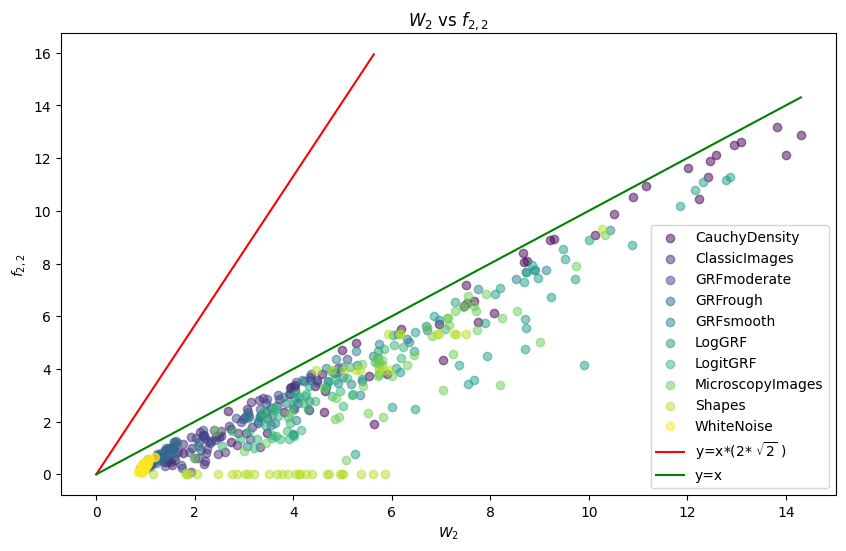

In [71]:
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, 10))  # 10 distinct colors
for i in range(10):  # 10 groups of 45 samples each
    start = i * 45
    end = (i + 1) * 45
    plt.scatter(w_values[start:end], pfm_values_normal[start:end], color=colors[i], alpha=0.5, label=f'{category_names[i]}')
x = np.linspace(0, np.max(w_values), 100)
plt.plot(x[:40], x[:40] * (2 * np.sqrt(2)), color='red', label='y=x*(2* $\sqrt{2}$ )')
plt.plot(x, x, color='green', label='y=x')
plt.title('$W_2$ vs $f_{2,2}$')
plt.ylabel('$f_{2,2}$')
plt.xlabel('$W_2$')
plt.legend()
plt.show()

We notice that the lower bound may be too strict, and that a bound of $W_2 \ge f_{2,2}$ may be a better fit

The upper bound, 
$$
W_2^2 \le \frac{T^3}{\pi} \cdot f_{2,2} \rightarrow W_2 \le \sqrt{\frac{T^3}{\pi} \cdot f_{2,2}}
$$

In [72]:
pfm_sqrt = np.sqrt(np.array(pfm_values_normal))
w_sqrt = np.sqrt(np.array(w_values))
pfm_sqrt_multipilied = pfm_sqrt * np.sqrt(T ** 3 / np.pi)

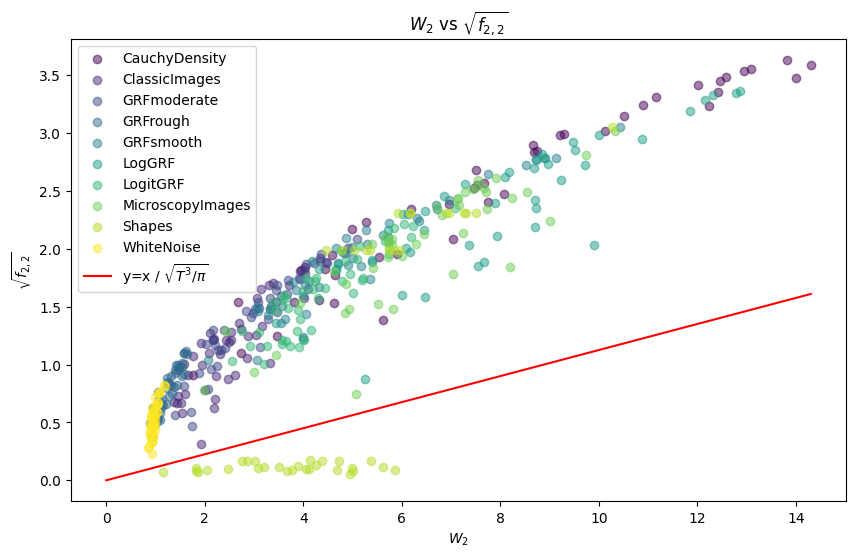

In [73]:
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, 10))  # 10 distinct colors
for i in range(10):  # 10 groups of 45 samples each
    start = i * 45
    end = (i + 1) * 45
    plt.scatter(w_values[start:end], pfm_sqrt[start:end], color=colors[i], alpha=0.5, label=f'{category_names[i]}')
x = np.linspace(0, np.max(w_values), 100)
plt.plot(x, x / np.sqrt(T ** 3 / np.pi), color='red', label='y=x / $\sqrt{T^3 / \pi}$')
plt.title('$W_2$ vs $\sqrt{f_{2,2}}$')
plt.ylabel('$\sqrt{f_{2,2}}$')
plt.xlabel('$W_2$')
plt.legend()
plt.show()

### Looking into the shapes group

In [102]:
category = 'Shapes'
pfm_values_shapes = []
w_values_shapes = []
category_dir = os.path.join(full_path, category)
for image_pair in pairs:
        # Loading and normalizing images
        path_im1 = os.path.join(category_dir, f"picture{resolution}_10{image_pair[0]}.png")
        im1 = cv2.imread(path_im1, cv2.IMREAD_GRAYSCALE)
        im1 = cv2.resize(im1, (resolution, resolution))
        im1 = im1 / im1.sum()  # Normalize
        path_im2 = os.path.join(category_dir, f"picture{resolution}_10{image_pair[1]}.png")
        im2 = cv2.imread(path_im2, cv2.IMREAD_GRAYSCALE)
        im2 = cv2.resize(im2, (resolution, resolution))
        im2 = im2 / im2.sum()  # Normalize
        
        pfm = Fourier2(im1, im2)
        pfm_values_shapes.append(pfm)

        #Calculate the EMD
        # cost_matrix = calculate_costs(im1.shape, distance_metric = 'L2')
        w_dist = np.sqrt(ot.emd2(im1.flatten(), im2.flatten(), cost_matrix_l2))
        w_values_shapes.append(w_dist)

In [103]:
pfm_sqrt = np.sqrt(np.array(pfm_values_shapes))
pfm_sqrt_multipilied = pfm_sqrt * np.sqrt(T ** 3 / np.pi)

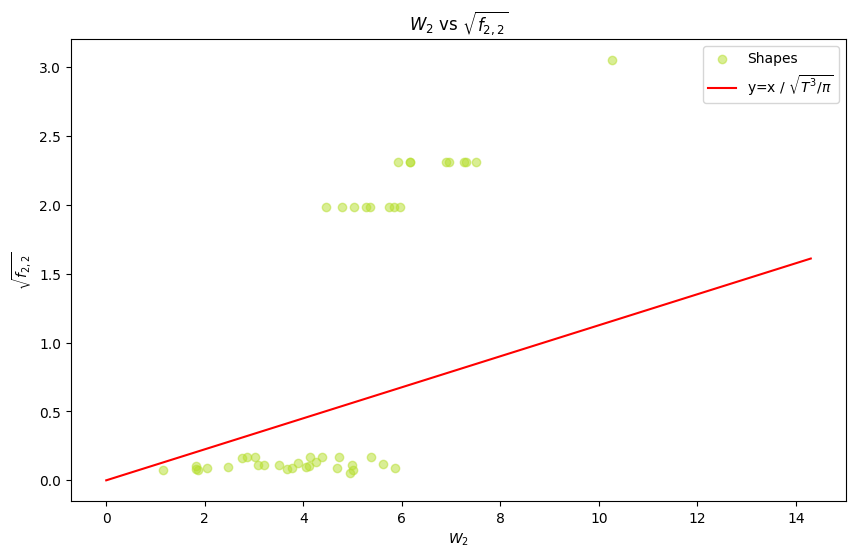

In [121]:
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, 10))  # 10 distinct colors
i = 8
plt.scatter(w_values_shapes, pfm_sqrt, color=colors[i], alpha=0.5, label=f'{category_names[i]}')
x = np.linspace(0, np.max(w_values), 100)
plt.plot(x, x / np.sqrt(T ** 3 / np.pi), color='red', label='y=x / $\sqrt{T^3 / \pi}$')
plt.title('$W_2$ vs $\sqrt{f_{2,2}}$')
plt.ylabel('$\sqrt{f_{2,2}}$')
plt.xlabel('$W_2$')
plt.legend()
plt.show()

In [122]:
images_below_line = []
for pfm, w_dist, pair in zip(pfm_sqrt, w_values_shapes, pairs):
    if pfm < w_dist * (np.sqrt(np.pi / (T ** 3))):
        images_below_line.append(pair)

# Now, images_below_line contains the pairs of images that are below the line.
# Let's print them out
for image_pair in images_below_line:
    print(f"Image pair below the line: {image_pair[0]} and {image_pair[1]}")

Image pair below the line: 01 and 02
Image pair below the line: 01 and 03
Image pair below the line: 01 and 04
Image pair below the line: 01 and 05
Image pair below the line: 01 and 08
Image pair below the line: 01 and 09
Image pair below the line: 01 and 10
Image pair below the line: 02 and 03
Image pair below the line: 02 and 04
Image pair below the line: 02 and 05
Image pair below the line: 02 and 08
Image pair below the line: 02 and 09
Image pair below the line: 02 and 10
Image pair below the line: 03 and 04
Image pair below the line: 03 and 05
Image pair below the line: 03 and 08
Image pair below the line: 03 and 09
Image pair below the line: 03 and 10
Image pair below the line: 04 and 05
Image pair below the line: 04 and 08
Image pair below the line: 04 and 09
Image pair below the line: 04 and 10
Image pair below the line: 05 and 08
Image pair below the line: 05 and 09
Image pair below the line: 05 and 10
Image pair below the line: 08 and 09
Image pair below the line: 08 and 10
I

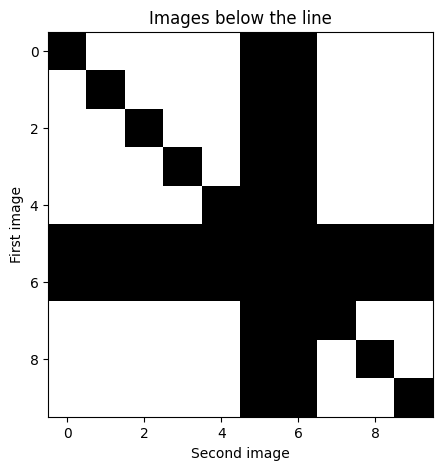

In [123]:
vis_mat = np.zeros((10, 10))
for pair in images_below_line:
    vis_mat[int(pair[0]) - 1, int(pair[1]) - 1] = 1
    vis_mat[int(pair[1]) - 1, int(pair[0]) - 1] = 1

plt.figure(figsize=(5, 5))
plt.imshow(vis_mat, cmap='gray')
plt.title('Images below the line')
plt.xlabel('Second image')
plt.ylabel('First image')
plt.show()

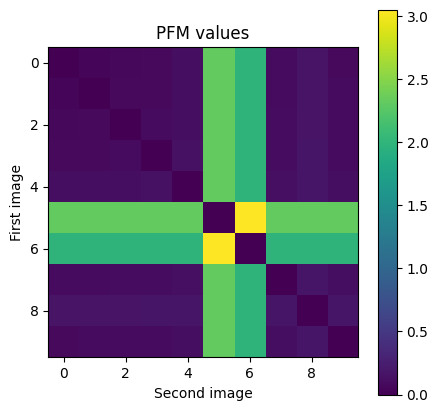

In [124]:
pfm_values_mat = np.zeros((10, 10))
w_values_mat = np.zeros((10, 10))
for pfm, w_dist, pair in zip(pfm_sqrt, w_values_shapes, pairs):
    pfm_values_mat[int(pair[0]) - 1, int(pair[1]) - 1] = pfm
    pfm_values_mat[int(pair[1]) - 1, int(pair[0]) - 1] = pfm
    w_values_mat[int(pair[0]) - 1, int(pair[1]) - 1] = w_dist
    w_values_mat[int(pair[1]) - 1, int(pair[0]) - 1] = w_dist

plt.figure(figsize=(5, 5))
plt.imshow(pfm_values_mat, cmap='viridis')
plt.title('PFM values')
plt.xlabel('Second image')
plt.ylabel('First image')
plt.colorbar()
plt.show()


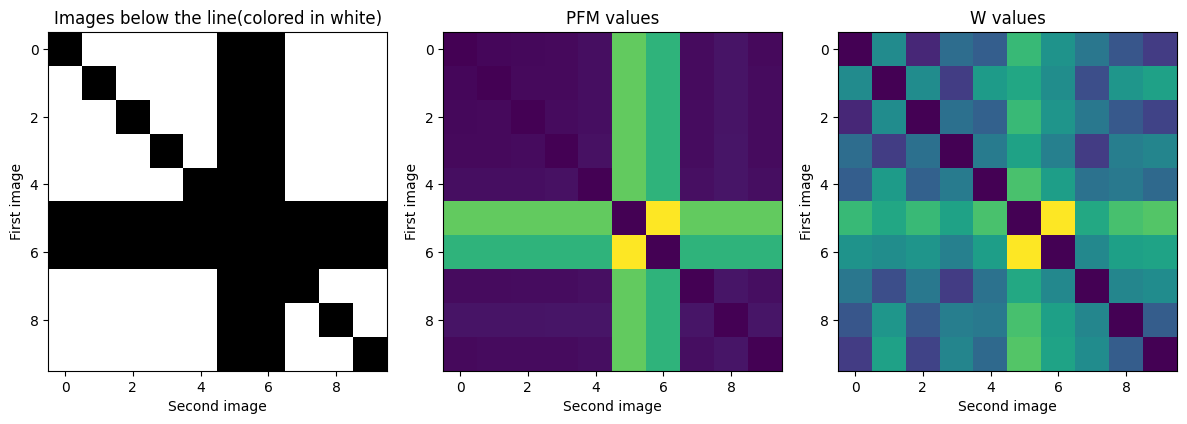

In [126]:
# Plot both next to each other
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(vis_mat, cmap='gray')
axs[0].set_title('Images below the line(colored in white)')
axs[0].set_xlabel('Second image')
axs[0].set_ylabel('First image')
axs[1].imshow(pfm_values_mat, cmap='viridis')
axs[1].set_title('PFM values')
axs[1].set_xlabel('Second image')
axs[1].set_ylabel('First image')
axs[2].imshow(w_values_mat, cmap='viridis')
axs[2].set_title('W values')
axs[2].set_xlabel('Second image')
axs[2].set_ylabel('First image')
plt.tight_layout()
plt.show()


This means that images 6 and 7 are problematic, let us look into all the images:

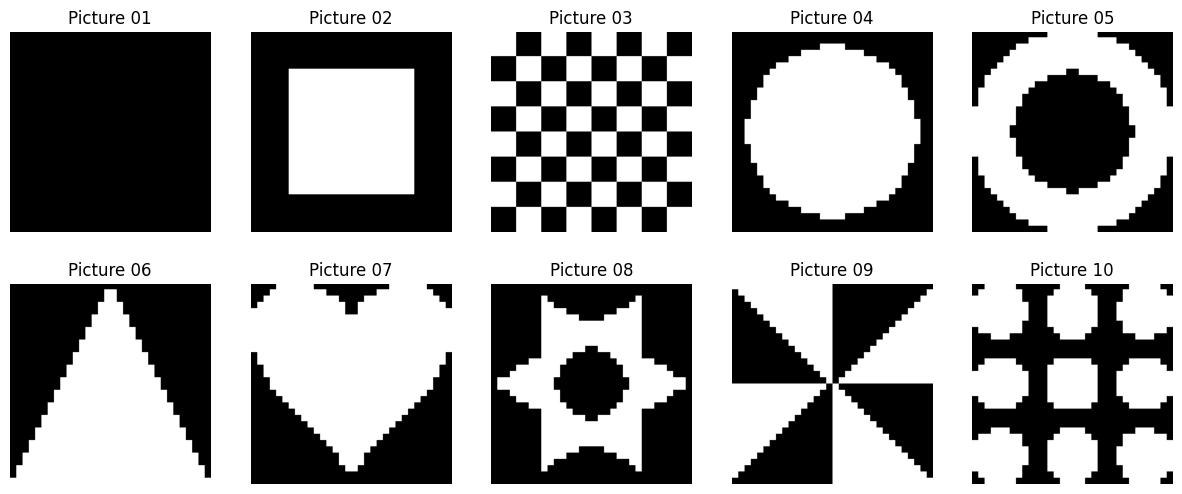

In [127]:
# Show all images in the category
category = 'Shapes'
category_dir = os.path.join(full_path, category)
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    path_im = os.path.join(category_dir, f"picture{resolution}_10{image_numbers[i]}.png")
    im = cv2.imread(path_im, cv2.IMREAD_GRAYSCALE)
    axs[i // 5, i % 5].imshow(im, cmap='gray')
    axs[i // 5, i % 5].set_title(f"Picture {image_numbers[i]}")
    axs[i // 5, i % 5].axis('off')

In [77]:
ratios = np.array(w_values) / np.array(pfm_sqrt)

In [78]:
print(max(ratios))
print(np.sqrt(T ** 3 / np.pi))

88.51257380882835
8.885765876316732


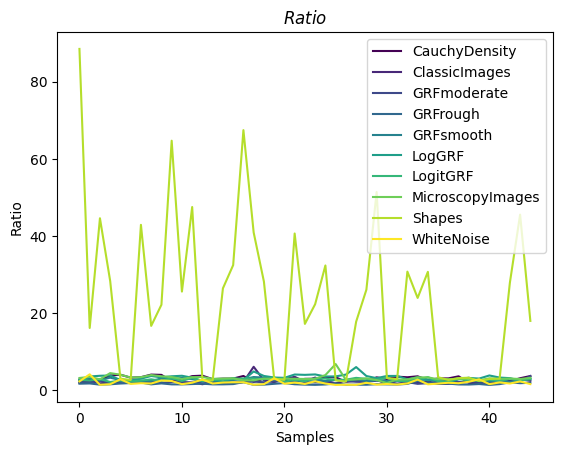

In [79]:
for i in range(10):
    start = i * 45
    end = (i + 1) * 45
    plt.plot(ratios[start:end], color=colors[i], label=f'{category_names[i]}')

plt.xlabel('Samples')
plt.ylabel('Ratio')
plt.legend()
plt.title('$Ratio$')
plt.show()

## Images, $W_1$ vs $f_{1,2}$

In [5]:
pfm_values_normal = []
pfm_values_simplified = []
w_values = []
T = 2 * np.pi
cost_matrix_l1 = calculate_costs((resolution, resolution), distance_metric = 'L1')

for category in category_names:
    category_dir = os.path.join(full_path, category)
    start = time.time()
    for image_pair in pairs:
        # Loading and normalizing images
        path_im1 = os.path.join(category_dir, f"picture{resolution}_10{image_pair[0]}.png")
        im1 = cv2.imread(path_im1, cv2.IMREAD_GRAYSCALE)
        im1 = cv2.resize(im1, (resolution, resolution))
        im1 = im1 / im1.sum()  # Normalize
        path_im2 = os.path.join(category_dir, f"picture{resolution}_10{image_pair[1]}.png")
        im2 = cv2.imread(path_im2, cv2.IMREAD_GRAYSCALE)
        im2 = cv2.resize(im2, (resolution, resolution))
        im2 = im2 / im2.sum()  # Normalize
        
        pfm = Fourier1(im1, im2)
        pfm_values_normal.append(pfm)

        #Calculate the EMD
        # cost_matrix = calculate_costs(im1.shape, distance_metric = 'L1')
        w_dist = ot.emd2(im1.flatten(), im2.flatten(), cost_matrix_l1)
        w_values.append(w_dist)
    
    end = time.time()
    print(f'{end - start} Time elapsed for Category {category}')

4.417735576629639 Time elapsed for Category CauchyDensity
6.9749791622161865 Time elapsed for Category ClassicImages
6.1616692543029785 Time elapsed for Category GRFmoderate
6.643928050994873 Time elapsed for Category GRFrough
6.598703145980835 Time elapsed for Category GRFsmooth
4.60918402671814 Time elapsed for Category LogGRF
5.388293504714966 Time elapsed for Category LogitGRF
2.898756980895996 Time elapsed for Category MicroscopyImages
1.6191527843475342 Time elapsed for Category Shapes
6.819622278213501 Time elapsed for Category WhiteNoise


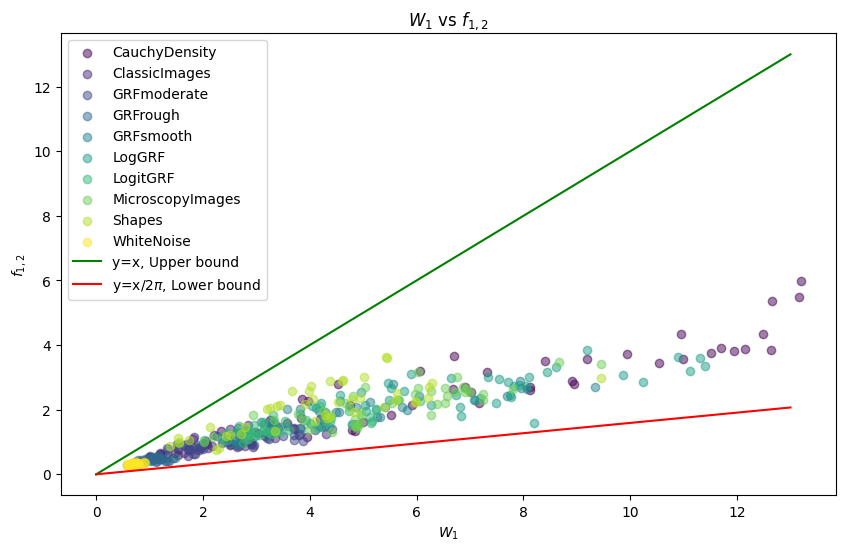

In [11]:
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, 10))  # 10 distinct colors
for i in range(10):  # 10 groups of 45 samples each
    start = i * 45
    end = (i + 1) * 45
    plt.scatter(w_values[start:end], pfm_values_normal[start:end], color=colors[i], alpha=0.5, label=f'{category_names[i]}')

# draw a line of y=x
x = np.linspace(0, 13, 100)
plt.plot(x, x, color='green', label='y=x, Upper bound')
plt.plot(x, x / (2 * np.pi), color='red', label='y=x/2$\pi$, Lower bound')
plt.title('$W_1$ vs $f_{1,2}$')
plt.xlabel('$W_1$')
plt.ylabel('$f_{1,2}$')
plt.legend()
plt.show()

In [39]:
ratios = np.array(w_values) / (np.array(pfm_values_normal) )

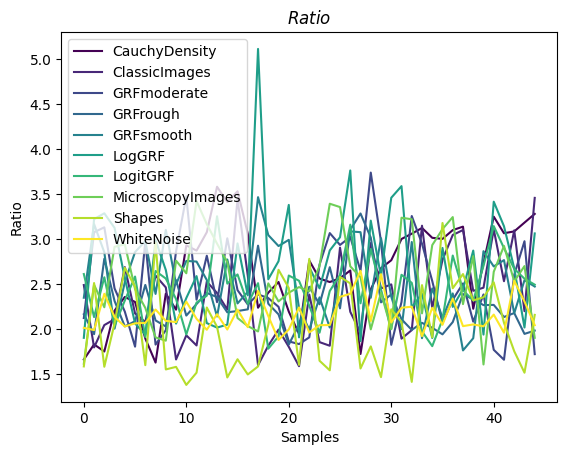

In [40]:
for i in range(10):
    start = i * 45
    end = (i + 1) * 45
    plt.plot(ratios[start:end], color=colors[i], label=f'{category_names[i]}')

plt.xlabel('Samples')
plt.ylabel('Ratio')
plt.legend()
plt.title('$Ratio$')
plt.show()